<a href="https://colab.research.google.com/github/Alirzeanoroozi/deep_learning_codes/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset


torch.manual_seed(1)
batch_size = 64
num_epochs = 20
learning_rate = 0.001

In [ ]:
device = torch.device("cuda:0")

## DATA


In [ ]:
# Data
image_path = './'

transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = torchvision.datasets.MNIST(root=image_path, train=True, transform=transform, download=True)

mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path, train=False, transform=transform, download=False)

train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)

In [ ]:
# Model
from collections import OrderedDict

# Model
model = nn.Sequential(OrderedDict([
    ('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2)),
    ('relu1', nn.ReLU()),
    ('pool1', nn.MaxPool2d(kernel_size=2)),

    ('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)),
    ('relu2', nn.ReLU()),
    ('pool2', nn.MaxPool2d(kernel_size=2)),

    ('flatten', nn.Flatten()),
    ('fc1', nn.Linear(3136, 1024)),
    ('relu3', nn.ReLU()),
    ('dropout', nn.Dropout(p=0.5)),
    ('fc2', nn.Linear(1024, 10))
]))

cnn_model = model.to(device)

In [ ]:
# Train
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)

                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid


hist = train(model, num_epochs, train_loader, test_loader)

In [ ]:
# Plot
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')

ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [ ]:
# test and evaluate
torch.cuda.synchronize()
model_cpu = model.cpu()
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

Test accuracy: 0.9896


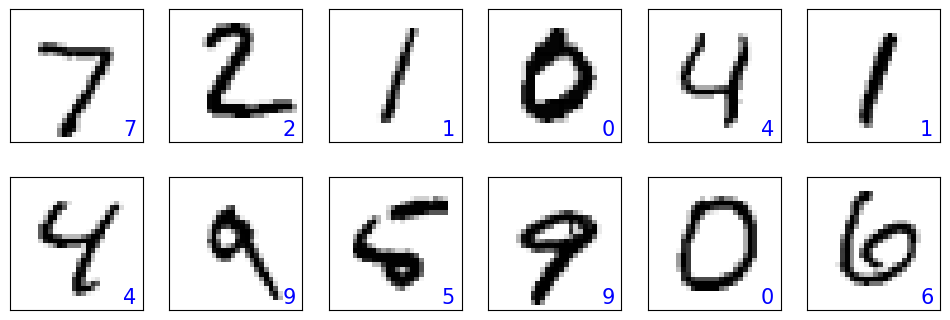

In [ ]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(),
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)

plt.show()

In [ ]:
fig = plt.figure(figsize=(12, 4))
num_miss_match = 0
for i in range(len(mnist_test_dataset)):
    img = mnist_test_dataset[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    if mnist_test_dataset[i][1] != y_pred.item():
      num_miss_match += 1
      ax = fig.add_subplot(5, 20, num_miss_match)
      ax.set_xticks([]); ax.set_yticks([])
      ax.imshow(img, cmap='gray_r')
      ax.text(0.9, 0.1, y_pred.item(),
              size=15, color='blue',
              horizontalalignment='center',
              verticalalignment='center',
              transform=ax.transAxes)
      ax.text(0.1, 0.1, mnist_test_dataset[i][1],
              size=15, color='red',
              horizontalalignment='center',
              verticalalignment='center',
              transform=ax.transAxes)
plt.show()